# Imports, loading dataset and utility functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cbottle.visualizations import visualize
import xarray as xr
import pandas as pd
import cartopy.feature as cfeature
import os
import netCDF4 as nc

from grad_check import concat_dataset_and_extract_q_names, get_differences, load_conditioning_sst

In [2]:
# path_to_folder = "inference_output/1971_2020_global_toa_rad_169h"
# path_to_folder = "inference_output/1990_2020_global_toa_rad_169h"
# path_to_folder = "inference_output/2020_north_atlantic_rlut_96h"
# path_to_folder = "inference_output/2020_north_atlantic_rsut_24h_fixed_noise"
# path_to_folder = "inference_output/1-2July2021_TOA_rad_1h"
path_to_folder = "inference_output/jan_feb_2021_toa_radiation"

# check if concatenated dataset exists
if not os.path.exists(os.path.join(path_to_folder, "concatenated_dataset.nc")):
    concatenated_ds, _ = concat_dataset_and_extract_q_names(path_to_folder, additional_vars=['rsut'])
    concatenated_ds.to_netcdf(os.path.join(path_to_folder, "concatenated_dataset.nc"))
else:
    concatenated_ds = xr.open_dataset(os.path.join(path_to_folder, "concatenated_dataset.nc"))

times = pd.to_datetime(concatenated_ds.time.values, unit='s')

In [3]:
def get_symmetric_colorbar_limits(x):
    # Get the 99th percentile to remove outliers
    vmin = np.percentile(x, 0.01)
    vmax = np.percentile(x, 99.99)

    # Set symmetric color limits based on the most extreme value
    if abs(vmin) > abs(vmax):
        vmax = -vmin
    else:
        vmin = -vmax
    return {'vmin': vmin, 'vmax': vmax}

In [4]:
# Enable LaTeX rendering only if matplotlib can actually use LaTeX
def check_latex_available():
    """Test if matplotlib can actually use LaTeX by attempting a simple render."""
    import matplotlib
    
    # Save current backend and rcParams settings
    original_backend = matplotlib.get_backend()
    original_rcParams = plt.rcParams.copy()
    
    try:
        # Use Agg backend to avoid display issues
        test_fig = plt.figure()
        test_ax = test_fig.add_subplot(111)
        # Try to enable LaTeX
        plt.rcParams['text.usetex'] = True
        # Attempt to render simple LaTeX text
        test_ax.text(0.5, 0.5, r'$\alpha$')
        test_fig.canvas.draw()
        plt.close(test_fig)
        # Restore backend and all original settings
        matplotlib.use(original_backend, force=True)
        plt.rcParams.update(original_rcParams)
        return True
    except Exception as e:
        # print(f"LaTeX not available for matplotlib: {e}")
        # Restore backend and all original settings
        matplotlib.use(original_backend, force=True)
        plt.rcParams.update(original_rcParams)
        return False
if check_latex_available():
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (14, 6)
    plt.rcParams['font.size'] = 16
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Computer Modern Roman']
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'
    print("LaTeX rendering enabled.")
else:
    print("LaTeX not available. Using default matplotlib rendering.")

LaTeX rendering enabled.


# Plot sensitivity maps

## Plot the average for every month


=== PLOTTING GRADIENTS FOR Q: global_TOA_radiation ===

--- MONTH 1 ---
  Averaged gradient range: -0.011019 to 0.009368
  Colorbar limits: -0.010748 to 0.010748

--- MONTH 2 ---
  Averaged gradient range: -0.009346 to 0.014062
  Colorbar limits: -0.013664 to 0.013664

--- MONTH 3 ---
No data for month 3, skipping.

--- MONTH 4 ---
No data for month 4, skipping.

--- MONTH 5 ---
No data for month 5, skipping.

--- MONTH 6 ---
No data for month 6, skipping.

--- MONTH 7 ---
No data for month 7, skipping.

--- MONTH 8 ---
No data for month 8, skipping.

--- MONTH 9 ---
No data for month 9, skipping.

--- MONTH 10 ---
No data for month 10, skipping.

--- MONTH 11 ---
No data for month 11, skipping.

--- MONTH 12 ---
No data for month 12, skipping.


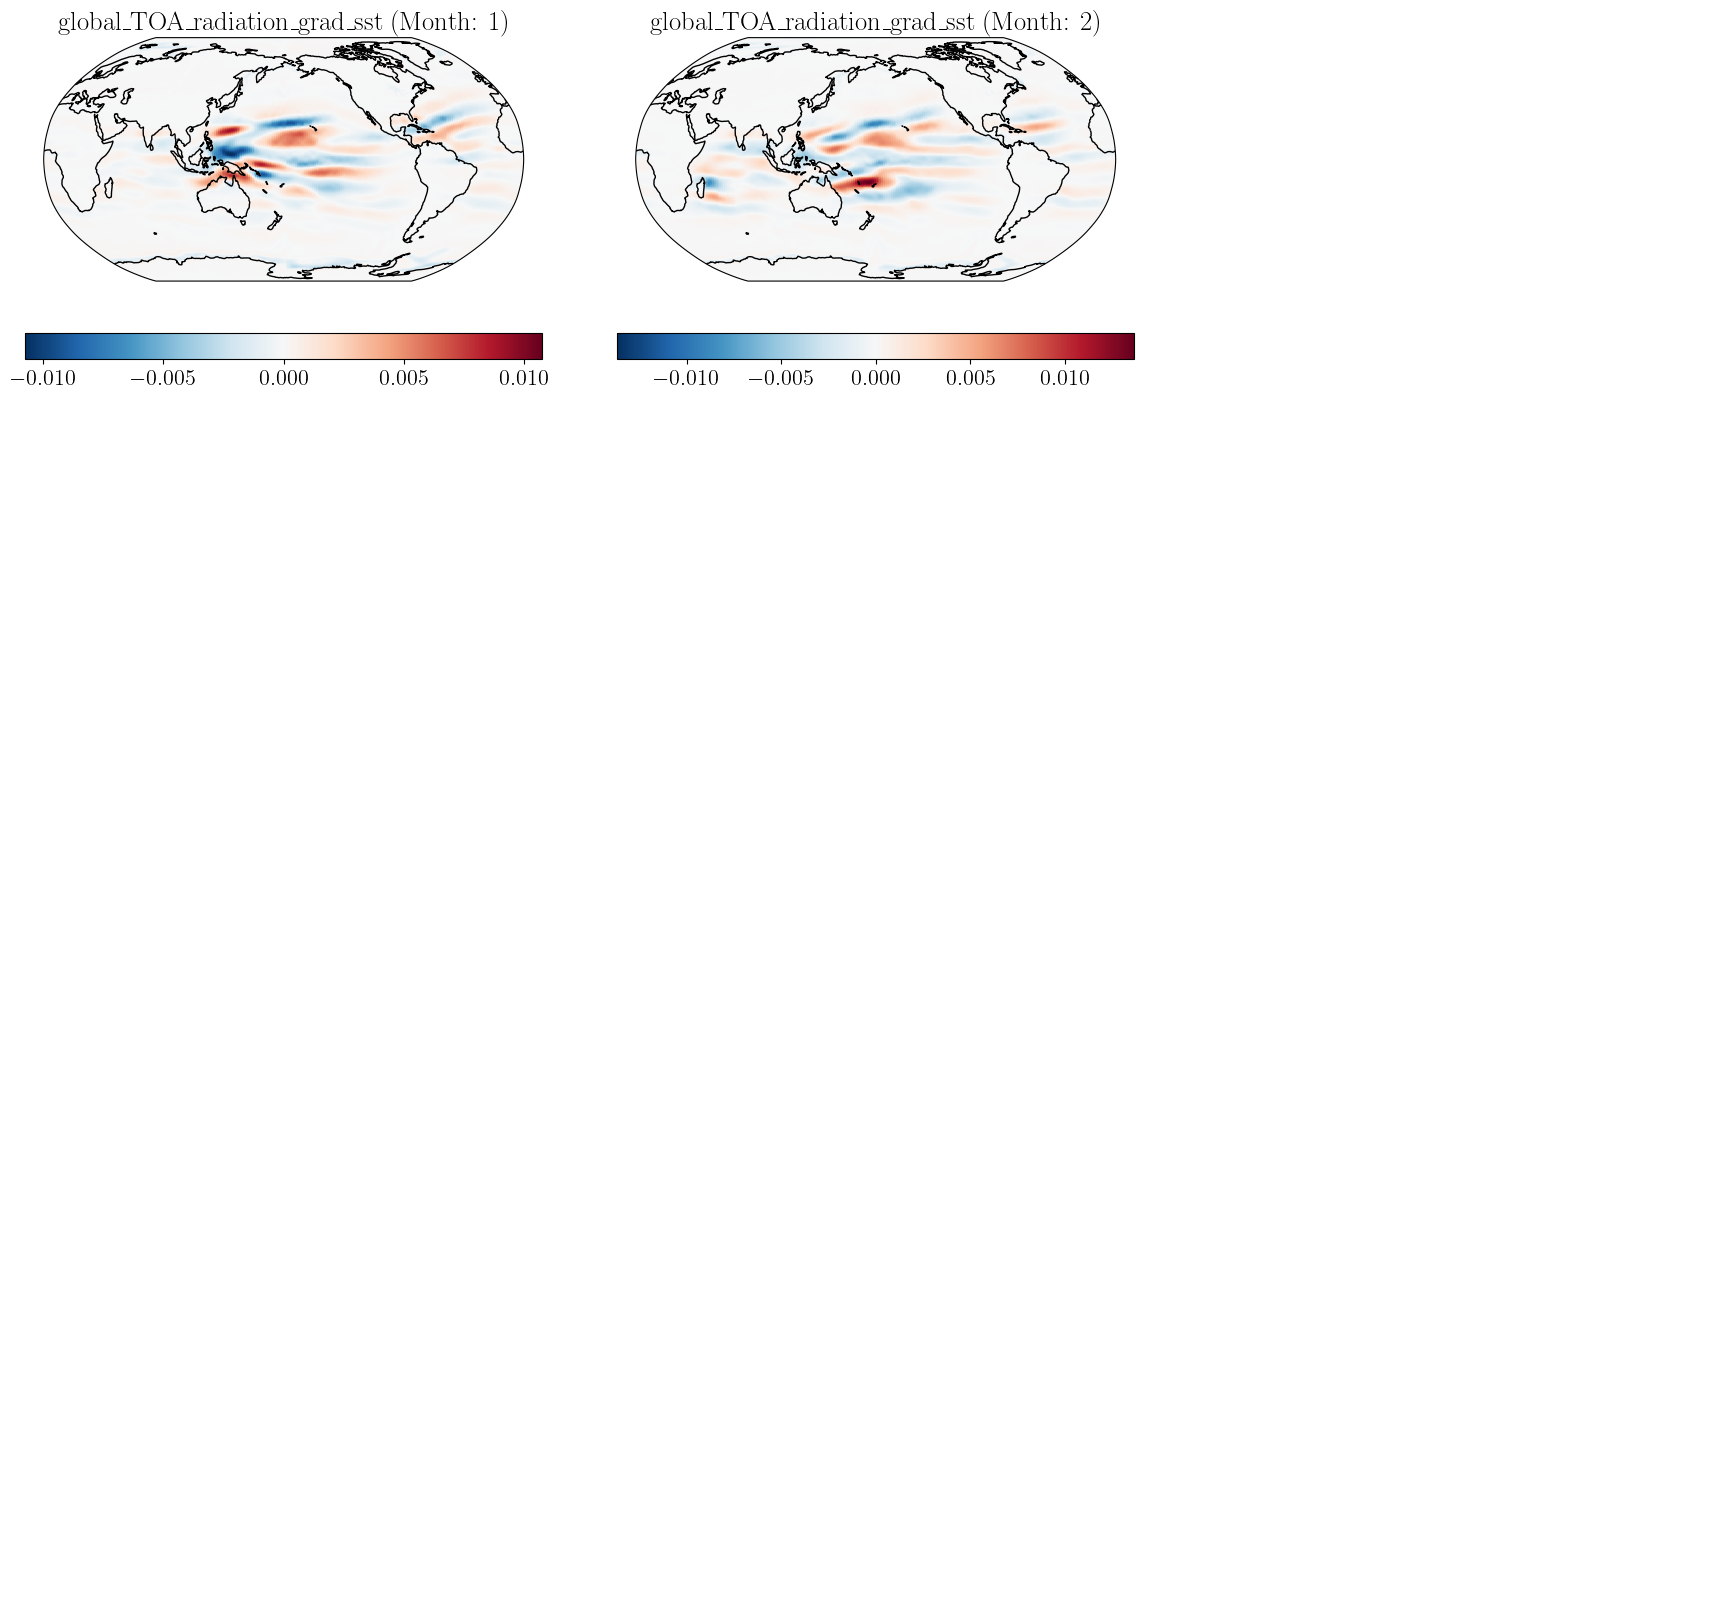

Saved figure to averaged_gradient_plots/0_monthly_jan_feb_2021_toa_radiation.png


In [5]:
q_names_to_plot = [
    "global_TOA_radiation",
    # "north_atlantic_rsut",
]
monthly_grad_data_list = []

# Use 4x3 layout if only one element, otherwise use 12xN layout
if len(q_names_to_plot) == 1:
    nrows, ncols = 4, 3
    fig, ax = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows * 0.7))
    ax = ax.flatten()  # Flatten for easier indexing
else:
    nrows, ncols = 12, len(q_names_to_plot)
    fig, ax = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows * 0.7))
    if ncols == 1:
        ax = ax.reshape(-1, 1)

for i, q_name in enumerate(q_names_to_plot):
    print(f"\n=== PLOTTING GRADIENTS FOR Q: {q_name} ===")
    grad_q_name = [f"{q_name}_grad_sst"]
    # Average the grad_q_name from dataset over each month
    for month in range(1, 13):
        print(f"\n--- MONTH {month} ---")
        # Get indices for this month
        month_indices = [idx for idx, t in enumerate(times) if t.month == month]
        if not month_indices:
            print(f"No data for month {month}, skipping.")
            continue
        
        # Average the gradients for this month
        grad_data_month = concatenated_ds[grad_q_name[0]].isel(time=month_indices).mean(dim='time').values
        monthly_grad_data_list.append(grad_data_month)

        # Get symmetric colorbar limits
        colorbar_limits = get_symmetric_colorbar_limits(grad_data_month)
        
        # Create the title with month information
        title = f"{grad_q_name[0]} (Month: {month})"
        
        print(f"  Averaged gradient range: {grad_data_month.min():.6f} to {grad_data_month.max():.6f}")
        print(f"  Colorbar limits: {colorbar_limits['vmin']:.6f} to {colorbar_limits['vmax']:.6f}")
        
        # Calculate subplot position based on layout
        if len(q_names_to_plot) == 1:
            # For 4x3 layout: row is (month-1)//3, col is (month-1)%3
            subplot_idx = month
        else:
            # For 12xN layout: standard grid position
            subplot_idx = (month - 1) * len(q_names_to_plot) + i + 1
        
        # Create the gradient plot using the visualize function
        result = visualize(
            grad_data_month,  # Averaged gradient data for the month
            region="Robinson_180",  # Use specified projection
            title=title,
            cmap='RdBu_r',
            vmin=colorbar_limits['vmin'],
            vmax=colorbar_limits['vmax'],
            add_colorbar=True,
            pos=(nrows, ncols, subplot_idx),  # Grid position
        )

plt.tight_layout()

# remove spine and ticks and numbers
if len(q_names_to_plot) == 1:
    for a in ax:
        for spine in a.spines.values():
            spine.set_visible(False)
        a.tick_params(left=False, bottom=False)
        a.set_xticklabels([])
        a.set_yticklabels([])
else:
    for a in ax.flatten() if hasattr(ax, 'flatten') else ax:
        for spine in a.spines.values():
            spine.set_visible(False)
        a.tick_params(left=False, bottom=False)
        a.set_xticklabels([])
        a.set_yticklabels([])
plt.show()

output_dir = "averaged_gradient_plots"
os.makedirs(output_dir, exist_ok=True)
filename = f"{len(month_indices)}_monthly_{path_to_folder.split('/')[-1]}.png"
filepath = os.path.join(output_dir, filename)
fig.savefig(filepath, dpi=150, bbox_inches='tight')
print(f"Saved figure to {filepath}")
plt.close()


## Plot the averaged sensitivity map for all times

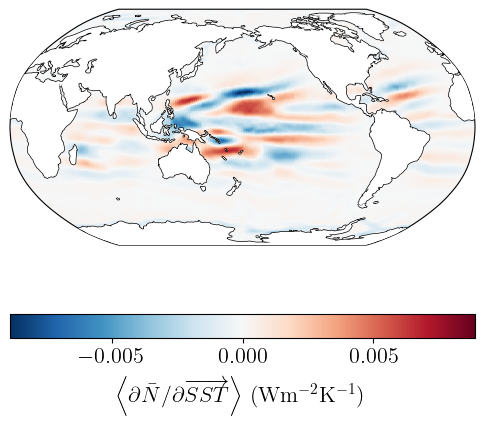

In [6]:
for q_name in q_names_to_plot:
    if "TOA" in q_name:
        colorbar_label = r"$\left<\partial \bar{N}/\partial \overrightarrow{SST}\right>$ (Wm$^{-2}$K$^{-1}$)"
    elif "pr" in q_name:
        colorbar_label = r"$\left<\partial \bar{pr}/\partial \overrightarrow{SST}\right>$ (mm day$^{-1}$ K$^{-1}$)"
    elif "north_atlantic_rlut" == q_name:
        colorbar_label = r"$\left<\partial \bar{R}_{LUT}/\partial \overrightarrow{SST}\right>$ (Wm$^{-2}$K$^{-1}$)"
    else:
        print(f"Unknown q_name {q_name} for setting colorbar label.")
        break

    # Also plot the average of all months together.
    avg_all_months_grad = np.mean(np.array(monthly_grad_data_list), axis=0)
    fig = plt.figure(figsize=(6, 6))

    colorbar_limits = get_symmetric_colorbar_limits(avg_all_months_grad)
    viz_result = visualize(
        avg_all_months_grad,  # Averaged gradient data for all months
        region="Robinson_180",  # Use specified projection
        # title="Average Gradient Across All Months",
        cmap='RdBu_r',
        vmin=colorbar_limits['vmin'],
        vmax=colorbar_limits['vmax'],
        colorbar_label=colorbar_label,
        )
    viz_result.ax.add_feature(cfeature.LAND, zorder=10, facecolor='white')

    plt.savefig(f"{len(times)}_{q_name}_all_months.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


# Plot gradient-check figure

In [7]:
import torch
import cartopy.feature as cfeature
import cartopy.crs as ccrs

## Load SST

In [8]:
sst_conditioning = await load_conditioning_sst(times)   # only works in notebook, asyncio.run needs to be used in python script

SST data already exists at /home/alexd/.cache/cbottle/tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc
/home/alexd/.cache/cbottle/tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc


In [9]:
finite_diff_sst = torch.diff(sst_conditioning, dim=0)  # shape (time-1, hpx)
typical_sst_diff = finite_diff_sst[0]  # shape (hpx,)

visualize(typical_sst_diff.numpy(), region="Robinson_180", title="Typical SST Difference Between Time Steps", cmap='RdBu_r', add_colorbar=True)

namespace(ax=<GeoAxes: title={'center': 'Typical SST Difference Between Time Steps'}>,
          im=<cartopy.mpl.geocollection.GeoQuadMesh at 0x718a1e1e2f90>,
          cb=<matplotlib.colorbar.Colorbar at 0x718a1d98db50>)

## Plot

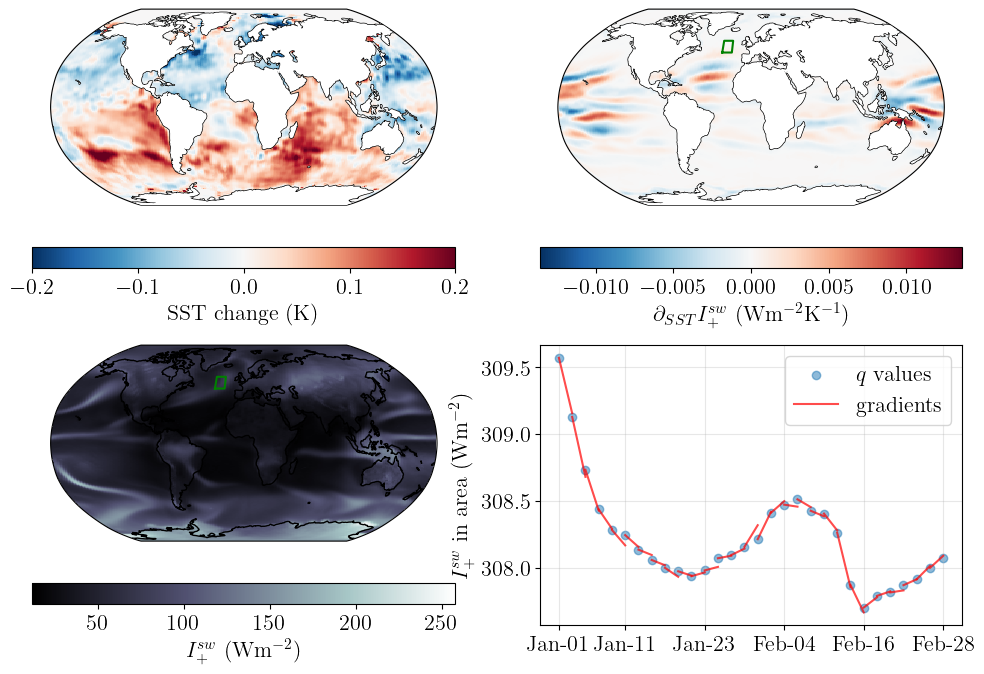

In [14]:
time_idx = 9
channel_to_plot = "rsut"
q_name = "global_TOA_radiation"
lon_min, lon_max, lat_min, lat_max = -30, -20, 45, 55
box_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
box_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]

# Reorder with increasing time
concatenated_ds = concatenated_ds.assign({'sst_conditioning': (('time', 'pix'), sst_conditioning)})
concatenated_ds = concatenated_ds.sortby('time')
sst_conditioning = torch.tensor(concatenated_ds['sst_conditioning'].data)
times = concatenated_ds.indexes['time']

q_values_dict, delta_q_finite_dict, linearized_delta_q_dict = get_differences(concatenated_ds, [q_name], sst_conditioning, times)

# Plot typical SST finite difference on the top left. Plot sensitivity map on the top right. Plot channel_to_plot on the bottom left. Plot the grad-check on the bottom right.
# Create figure with 2x2 subplots
fig = plt.figure(figsize=(12, 8))
sst_diff_cbar_limits = get_symmetric_colorbar_limits(finite_diff_sst[time_idx].numpy())
# Top-left: Typical SST finite difference
result_sst_diff = visualize(
    finite_diff_sst[time_idx].numpy(),
    region="Robinson",
    cmap='RdBu_r',
    vmin=-0.2,
    vmax=0.2,
    pos=(2, 2, 1),
    add_colorbar=True,
    colorbar_label="SST change (K)",
)
result_sst_diff.ax.add_feature(cfeature.LAND, zorder=10, facecolor='white')

# Top-right: sensitivity map
sensitivity_map = concatenated_ds[q_name + '_grad_sst'][time_idx].values
sensitivity_map_cbar_limits = get_symmetric_colorbar_limits(sensitivity_map)
result_sensitivity = visualize(
    sensitivity_map,
    region="Robinson",
    cmap='RdBu_r',
    **sensitivity_map_cbar_limits,
    pos=(2, 2, 2),
    add_colorbar=True,
    colorbar_label=r"$\partial_{SST} I_{+}^{sw}$ (Wm$^{-2}$K$^{-1}$)",
)
result_sensitivity.ax.add_feature(cfeature.LAND, zorder=10, facecolor='white')
result_sensitivity.ax.plot(box_lons, box_lats, color='green', linewidth=1.5, transform=ccrs.PlateCarree())

# Bottom-left: channel_to_plot
channel_data = concatenated_ds[channel_to_plot][time_idx].values
result_channel = visualize(
    channel_data,
    region="Robinson",
    cmap='bone',
    pos=(2, 2, 3),
    add_colorbar=True,
    colorbar_label=r"$I_{+}^{sw}$ (Wm$^{-2}$)",
)
result_channel.ax.plot(box_lons, box_lats, color='green', linewidth=1.5, transform=ccrs.PlateCarree())

# Bottom-right: grad-check
num_values_to_plot = 64
q_values = q_values_dict[q_name][:num_values_to_plot]
delta_q_finite = delta_q_finite_dict[q_name][:num_values_to_plot]
linearized_delta_q = linearized_delta_q_dict[q_name][:num_values_to_plot]
times_to_plot = times[:num_values_to_plot]

ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(range(len(q_values)), q_values.numpy(), label=r"$q$ values", alpha=0.5)
for t in range(len(linearized_delta_q)):    # only plot up to T-1 as that is how many finite diffs we have
    plt.plot([t, t+1], [q_values[t].item(), q_values[t].item() + linearized_delta_q[t].item()],label="gradients" if t==0 else None, color='red', alpha=0.7)

ax4.set_ylabel(r"$I_{+}^{sw}$ in area (Wm$^{-2}$)")
ax4.grid(True, alpha=0.3)
ax4.legend()
num_ticks = min(6, len(times_to_plot))
tick_indices = [int(i * (len(times_to_plot) - 1) / (num_ticks - 1)) for i in range(num_ticks)] if num_ticks > 1 else [0]
plt.xticks(tick_indices)
plt.gca().set_xticklabels([times_to_plot[i].strftime('%b-%d') for i in tick_indices], rotation=0)
plt.show()

# Plot adjoint propagation illustration

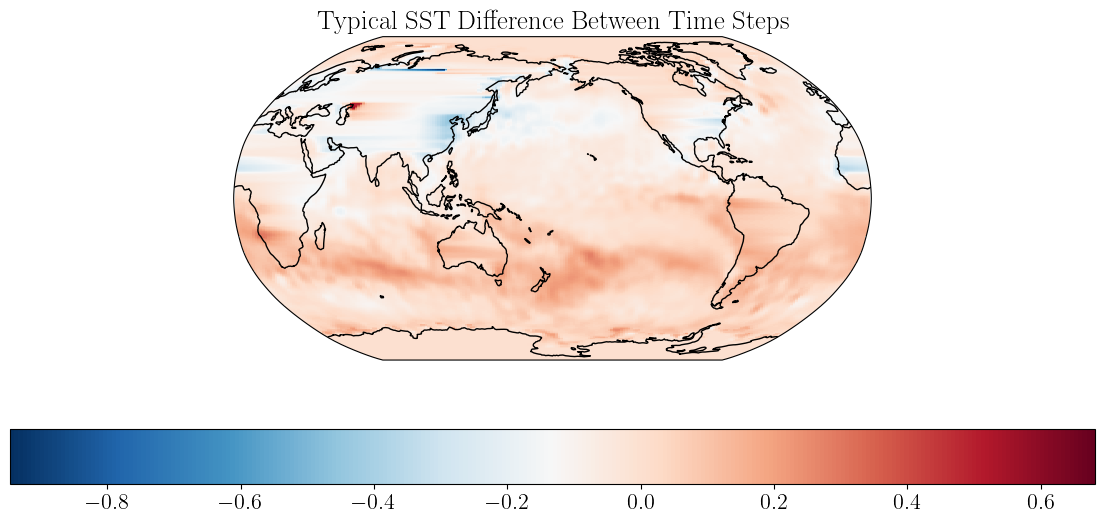

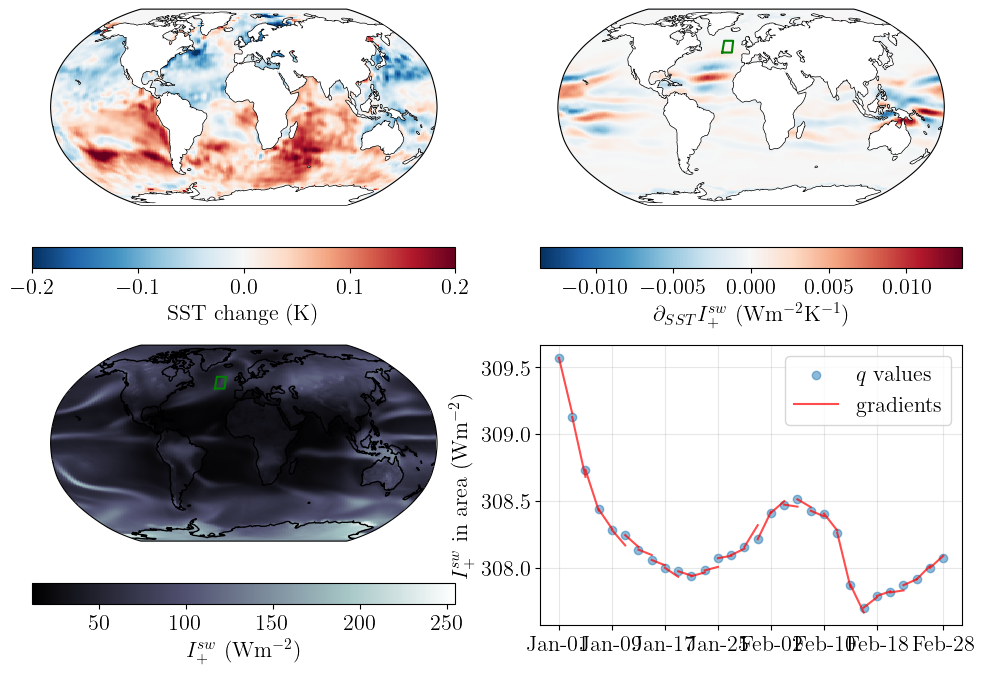

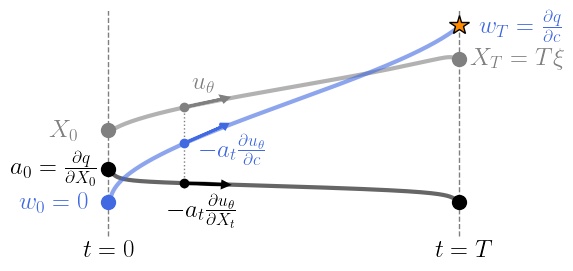

In [11]:
# Set up the figure
fig, ax2 = plt.subplots(1, 1, figsize=(6, 3))

# Time points (we'll use this as x-axis, with t=T on right, t=0 on left)
t = np.linspace(0, 5, 1000)

# Forward flow trajectory (grey) - from T*xi at t=T to X_0 at t=0
# This should be a smooth curve going from right to left
Txi_position = [4.8, 2.5]  # Starting position at t=T
X_0_position = [0.2, 1.0]  # Ending position at t=0

# Create smooth trajectory using a sigmoid-like function
forward_x = 4.8 - 4.6 * (1 / (1 + np.exp(-2 * (t - 2.5))))
forward_y = 2.5 - 1.5 * (1 / (1 + np.exp(-1.5 * (t - 2.5)))) + 0.3 * np.sin(0.8 * t) * np.exp(-0.3 * t)

# Plot forward flow trajectory in grey
ax2.plot(forward_x, forward_y, color='grey', linewidth=3, alpha=0.6, zorder=3)

# Mark X_0 at t=0 (left end) and T*xi at t=T (right end)
ax2.plot(X_0_position[0], X_0_position[1], 'o', color='grey', markersize=10, zorder=5)
ax2.plot(Txi_position[0], Txi_position[1], 'o', color='grey', markersize=10, zorder=5)

# Add LaTeX labels for the forward trajectory endpoints
ax2.text(X_0_position[0] - 0.4, X_0_position[1], r'$X_0$', 
        fontsize=18, color='grey', fontweight='bold', 
        verticalalignment='center', horizontalalignment='right', zorder=6)
ax2.text(Txi_position[0] + 0.15, Txi_position[1], r'$X_T=T\xi$', 
        fontsize=18, color='grey', fontweight='bold', 
        verticalalignment='center', horizontalalignment='left', zorder=6)

# Backward adjoint trajectory (black) - from ∂q/∂X_0 at t=0 to t=T
adjoint_start = [0.2, 0.2]  # Starting at t=0
adjoint_end = [4.8, -0.5]   # Ending at t=T

# Create smooth backward trajectory
adjoint_x = 0.2 + 4.6 * (1 / (1 + np.exp(-2 * (t - 2.5))))
adjoint_y = 0.2 - 0.7 * (1 / (1 + np.exp(-1.5 * (t - 2.5)))) - 0.2 * np.sin(1.2 * t) * np.exp(-0.2 * t)

# Plot backward adjoint trajectory in black
ax2.plot(adjoint_x, adjoint_y, color='black', linewidth=3, alpha=0.6, zorder=3)

# Mark the starting point of adjoint (∂q/∂X_0) and ending point
ax2.plot(adjoint_start[0], adjoint_start[1], 'o', color='black', markersize=10, zorder=5)
ax2.plot(adjoint_end[0], adjoint_end[1], 'o', color='black', markersize=10, zorder=5)

# Add LaTeX label for adjoint starting point
ax2.text(adjoint_start[0] - 0.15, adjoint_start[1], r'$a_0=\frac{\partial q}{\partial X_0}$', 
        fontsize=18, color='black', fontweight='bold', 
        verticalalignment='center', horizontalalignment='right', zorder=6)

# Backward gradient trajectory (royalblue) - from w_0=0 at t=0 to w_T=∂q/∂c at t=T
gradient_start = [0.2, -0.5]  # Starting at t=0 (w_0 = 0)
gradient_end = [4.8, 3.2]     # Ending at t=T (w_T = ∂q/∂c)

# Create smooth gradient trajectory
gradient_x = 0.2 + 4.6 * (1 / (1 + np.exp(-2 * (t - 2.5))))
gradient_y = -0.5 + 3.7 * (1 / (1 + np.exp(-1.5 * (t - 2.5)))) + 0.4 * np.sin(0.6 * t) * np.exp(-0.3 * t)

# Plot backward gradient trajectory in royalblue
ax2.plot(gradient_x, gradient_y, color='royalblue', linewidth=3, alpha=0.6, zorder=3)

# Mark the starting point (w_0 = 0) and ending point (w_T = ∂q/∂c)
ax2.plot(gradient_start[0], gradient_start[1], 'o', color='royalblue', markersize=10, zorder=5)
ax2.plot(gradient_end[0], gradient_end[1], '*', color='darkorange', markersize=15, zorder=5, 
        markeredgecolor='black', markeredgewidth=1)

# Add LaTeX labels for gradient trajectory
ax2.text(gradient_start[0] - 0.25, gradient_start[1], r'$w_0 = 0$', 
        fontsize=18, color='royalblue', fontweight='bold', 
        verticalalignment='center', horizontalalignment='right', zorder=6)
ax2.text(gradient_end[0] + 0.27, gradient_end[1], r'$w_T = \frac{\partial q}{\partial c}$', 
        fontsize=18, color='royalblue', fontweight='bold', 
        verticalalignment='center', horizontalalignment='left', zorder=6)

# Mark points at x=1.2 on all three trajectories with tangent arrows
x_mark = 1.2

# Find y-values at x=1.2 for each trajectory
# For forward trajectory
idx_forward = np.argmin(np.abs(forward_x - x_mark))
y_forward_mark = forward_y[idx_forward]

# For adjoint trajectory
idx_adjoint = np.argmin(np.abs(adjoint_x - x_mark))
y_adjoint_mark = adjoint_y[idx_adjoint]

# For gradient trajectory
idx_gradient = np.argmin(np.abs(gradient_x - x_mark))
y_gradient_mark = gradient_y[idx_gradient]

# Plot smaller dots at x=1.2
ax2.plot(x_mark, y_forward_mark, 'o', color='grey', markersize=6, zorder=5)
ax2.plot(x_mark, y_adjoint_mark, 'o', color='black', markersize=6, zorder=5)
ax2.plot(x_mark, y_gradient_mark, 'o', color='royalblue', markersize=6, zorder=5)

# Calculate tangent directions (approximate derivatives)
dx = 0.01
arrow_length = 0.5

# Forward trajectory - arrow pointing left (negative direction)
if idx_forward > 0 and idx_forward < len(forward_x) - 1:
    forward_slope = (forward_y[idx_forward+1] - forward_y[idx_forward-1]) / (forward_x[idx_forward+1] - forward_x[idx_forward-1])
else:
    forward_slope = (forward_y[idx_forward] - forward_y[idx_forward-1]) / (forward_x[idx_forward] - forward_x[idx_forward-1])

# Normalize and scale for arrow (pointing left)
forward_dx = arrow_length
forward_dy = forward_slope * forward_dx
ax2.arrow(x_mark, y_forward_mark, forward_dx, forward_dy, 
         head_width=0.12, head_length=0.08, fc='grey', ec='grey', linewidth=2, zorder=6)

# Adjoint trajectory - arrow pointing right (positive direction)
if idx_adjoint > 0 and idx_adjoint < len(adjoint_x) - 1:
    adjoint_slope = (adjoint_y[idx_adjoint+1] - adjoint_y[idx_adjoint-1]) / (adjoint_x[idx_adjoint+1] - adjoint_x[idx_adjoint-1])
else:
    adjoint_slope = (adjoint_y[idx_adjoint] - adjoint_y[idx_adjoint-1]) / (adjoint_x[idx_adjoint] - adjoint_x[idx_adjoint-1])

adjoint_dx = arrow_length
adjoint_dy = adjoint_slope * adjoint_dx
ax2.arrow(x_mark, y_adjoint_mark, adjoint_dx, adjoint_dy, 
         head_width=0.12, head_length=0.08, fc='black', ec='black', linewidth=2, zorder=6)

# Gradient trajectory - arrow pointing right (positive direction)
if idx_gradient > 0 and idx_gradient < len(gradient_x) - 1:
    gradient_slope = (gradient_y[idx_gradient+1] - gradient_y[idx_gradient-1]) / (gradient_x[idx_gradient+1] - gradient_x[idx_gradient-1])
else:
    gradient_slope = (gradient_y[idx_gradient] - gradient_y[idx_gradient-1]) / (gradient_x[idx_gradient] - gradient_x[idx_gradient-1])

gradient_dx = arrow_length
gradient_dy = gradient_slope * gradient_dx
ax2.arrow(x_mark, y_gradient_mark, gradient_dx, gradient_dy, 
         head_width=0.12, head_length=0.08, fc='royalblue', ec='royalblue', linewidth=2, zorder=6)

# Add vertical dotted line connecting the three points
y_min_mark = min(y_forward_mark, y_adjoint_mark, y_gradient_mark) - 0.1
y_max_mark = max(y_forward_mark, y_adjoint_mark, y_gradient_mark) + 0.1
ax2.plot([x_mark, x_mark], [y_min_mark, y_max_mark], 
        color='black', linestyle=':', linewidth=1, alpha=0.5, zorder=1)

# Add gradient value labels for each arrow
# Forward trajectory label (above the arrow)
ax2.text(x_mark + forward_dx/2, y_forward_mark + forward_dy/2 + 0.2, r'$u_{\theta}$', 
        fontsize=18, color='grey', fontweight='bold', 
        verticalalignment='bottom', horizontalalignment='center', zorder=6)

# Adjoint trajectory label (below the arrow)
ax2.text(x_mark + adjoint_dx/2, y_adjoint_mark + adjoint_dy/2 - 0.2, r'$-a_t\frac{\partial u_{\theta}}{\partial X_t}$', 
        fontsize=18, color='black', fontweight='bold', 
        verticalalignment='top', horizontalalignment='center', zorder=6)

# Gradient trajectory label (to the right of the arrow)
ax2.text(x_mark + gradient_dx - 0.3, y_gradient_mark + gradient_dy/2 - 0.3, r'$-a_t\frac{\partial u_{\theta}}{\partial c}$', 
        fontsize=18, color='royalblue', fontweight='bold', 
        verticalalignment='center', horizontalalignment='left', zorder=6)

# Add time axis labels
ax2.text(0.21, -1.5, r'$t = 0$', fontsize=18, color='black', fontweight='bold', 
        verticalalignment='center', horizontalalignment='center', zorder=6)
ax2.text(4.85, -1.5, r'$t = T$', fontsize=18, color='black', fontweight='bold', 
        verticalalignment='center', horizontalalignment='center', zorder=6)

# Add vertical dashed lines to mark t=0 and t=T (stopping at a lower bound to avoid clashing with text)
ax2.plot([0.2, 0.2], [-1.2, 4.0], color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
ax2.plot([4.8, 4.8], [-1.2, 4.0], color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=1)

# Customize the plot
ax2.set_xlim(-0.5, 5.5)
ax2.set_ylim(-1.5, 3.5)

# Remove all spines and ticks for cleaner look
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])

# Add subtle grid
# ax2.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)

plt.tight_layout()

# save in pdf format.
plt.savefig("adjoint_illustration.png", bbox_inches='tight', dpi=300)
plt.show()

